# CSC380 Final Project
Kieran Chafin, Shale Van Cleve

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import os # for `os.path.exists`
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler # scaler for plot and data

# interactive plot
%matplotlib widget 

## Part 1: Load the data
Here we use the 'os' import above to read the file data.

In [79]:
# takes a file name, sep's class and points into X and y, returns X as a label and y as a np column collection
def load_data(filename, data_dir="data"):
    # Verify file exists
    filepath = os.path.join("..", data_dir, filename) # Contruct full filepath

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Dataset file {filepath} not found")
    
    # Read just the header line
    with open(filepath, 'r') as f:
        header = f.readline().strip().replace('"', '')  # Remove quotes if present
    
    # split header, find the column for the class
    header_cols = [col.strip().lower() for col in header.split(',')]
    try:
        label_idx = header_cols.index('class')
    except ValueError:
        raise ValueError("No 'Class' column found in header")
    
    # store the rest of the data
    data = np.loadtxt(filepath, delimiter=',', skiprows=1)
    
    # separate features and labels
    y = data[:, label_idx].astype(int)  # Label column
    X = np.delete(data, label_idx, axis=1)  # All other columns
    
    return X, y

## Part 2: Plot and Tree Helpers
These functions below define helper for showing stats, generating combonations, and printing a visual tree for debugging.

In [80]:
# generate all combomations of points and classes for the SVM
def generate_combinations(classes):
    combos = []
    for c in classes:
        combos.append([c])

    #loop all classes for points
    for i in range(len(classes)):
        for j in range(i+1, len(classes)):
            combos.append([classes[i], classes[j]])
    return combos

# calculates the gini % for each plot (points vs SVM)
def calculate_gini(y_left, y_right):
    # Calculate weighted Gini impurity
    n_left, n_right = len(y_left), len(y_right)
    n_total = n_left + n_right
    
    def _gini(y):
        if len(y) == 0: return 0
        counts = np.bincount(y)
        probs = counts / len(y)
        return 1 - np.sum(probs**2)
    
    return (n_left/n_total)*_gini(y_left) + (n_right/n_total)*_gini(y_right)

# prints the decision tree by boundary
def print_tree(node, indent="", feature_names=["x", "y"]):
    if node.is_leaf:
        print(f"{indent}└── Class {node.class_label}")
        return

    # print node split (using SVM's decision boundary)
    if hasattr(node.svm_model, 'coef_'):
        w = node.svm_model.coef_[0]
        b = node.svm_model.intercept_[0]
        print(f"{indent}├── SVM: {w[0]:.2f}*{feature_names[0]} + {w[1]:.2f}*{feature_names[1]} + {b:.2f} >= 0")

    # recurse on children
    print(f"{indent}├── Left:")
    print_tree(node.left, indent + "│   ")
    print(f"{indent}└── Right:")
    print_tree(node.right, indent + "    ")

## Part 3: Tree definition.
The main tree class, for deisgning the decision tree.

In [81]:
class TreeNode:
    def __init__(self, is_leaf=False, class_label=None, svm_model=None):
        self.is_leaf = is_leaf              # True/False
        self.class_label = class_label      # Only for leaves
        self.svm_model = svm_model          # Trained SVC for non-leaves
        self.left = None                    # "Below" boundary child
        self.right = None                   # "Above/on" boundary child

## Part 4: Tree Building prediction.
Here we use a n depth tree to isolate the classes in the decision tree.
build_tree uses the depth update the gini, best svm, and the masking matrix.
predicts checks if there is 1 or more classes in a node of the decision tree.

In [82]:
# predicts
def predict(node, x):
    while not node.is_leaf:
        side = node.svm_model.predict([x])[0]  # 0=left, 1=right
        node = node.right if side == 1 else node.left
    return node.class_label

def build_tree(X, y, depth=0, max_depth=5, kernel='linear'):
    # Stopping conditions
    if (depth >= max_depth) or (len(X) < 10) or (len(np.unique(y)) == 1):
        if len(y) == 0:
            # If no data, return a default class (e.g., -1 or 0)
            return TreeNode(is_leaf=True, class_label=-1)
        majority_class = np.argmax(np.bincount(y))
        return TreeNode(is_leaf=True, class_label=majority_class)
    
    best_gini = float('inf')
    best_svm = None
    best_mask = None
    
    # Try all 1-class and 2-class combinations
    classes = np.unique(y)
    for class_combo in generate_combinations(classes):
        # Create binary labels: 1=selected class(es), 0=others
        y_binary = np.isin(y, class_combo).astype(int)
        if len(np.unique(y_binary)) < 2:
            continue  # Skip if only one class present

        # Train SVM
        svm = SVC(kernel=kernel).fit(X, y_binary)
        
        # Evaluate split using Gini index
        mask = svm.predict(X) == 1
        gini = calculate_gini(y[mask], y[~mask])
        
        if gini < best_gini:
            best_gini, best_svm, best_mask = gini, svm, mask
            print(f"Depth {depth}: Splitting {len(X)} points into {len(y[best_mask])}/{len(y[~best_mask])} (Gini: {best_gini:.3f})")

    if best_gini == float('inf'):  # No good split found
        majority_class = np.argmax(np.bincount(y))
        return TreeNode(is_leaf=True, class_label=majority_class)
    
    # Recursively build subtrees
    node = TreeNode(svm_model=best_svm)
    node.left = build_tree(X[~best_mask], y[~best_mask], depth+1, max_depth, kernel)
    node.right = build_tree(X[best_mask], y[best_mask], depth+1, max_depth, kernel)
    return node

## Part 5: Tree Visualizer
Defines the Plot for each set of data using an interactive plot.

In [83]:
def plot_boundaries(ax, node, x_range, y_range):
    """Recursively draw linear decision boundaries for a TreeNode-based tree."""
    if node.is_leaf:
        return
    
    # Get the SVM coefficients and intercept (w0*x + w1*y + b = 0)
    w = node.svm_model.coef_[0]
    b = node.svm_model.intercept_[0]
    
    # For plotting: solve for y = (-w0*x - b) / w1
    x_vals = np.linspace(x_range[0], x_range[1], 200)
    if w[1] != 0:
        y_vals = (-w[0] * x_vals - b) / w[1]
        ax.plot(x_vals, y_vals, 'k--')
    
    # Recursively plot boundaries in left and right subtrees
    plot_boundaries(ax, node.left, x_range, y_range)
    plot_boundaries(ax, node.right, x_range, y_range)

def visualize_tree(tree, X_original, y, scaler, title="Decision Boundaries"):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # decision surface
    x_min, x_max = X_original[:, 0].min() - 0.5, X_original[:, 0].max() + 0.5
    y_min, y_max = X_original[:, 1].min() - 0.5, X_original[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    grid_scaled = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array([predict(tree, point) for point in grid_scaled])
    Z = Z.reshape(xx.shape)
    
    contour = ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = ax.scatter(X_original[:, 0], X_original[:, 1], c=y, cmap='viridis', edgecolor='k')
    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    if "data4" not in title.lower():
        plot_boundaries(ax, tree, (x_min, x_max), (y_min, y_max))
    
    annotation = None

    def on_click(event):
        nonlocal annotation
        if event.inaxes != ax:
            return
        click_point = np.array([[event.xdata, event.ydata]])
        scaled_point = scaler.transform(click_point)
        prediction = predict(tree, scaled_point[0])
    
        print(f"Clicked point ({event.xdata:.2f}, {event.ydata:.2f}) -> Class: {prediction}")
        
        # Remove old annotation
        if annotation:
            annotation.remove()
        
        # Add new annotation
        annotation = ax.annotate(f"Class: {prediction}",
                                  (event.xdata, event.ydata),
                                  textcoords="offset points",
                                  xytext=(10, 10),
                                  color="red",
                                  fontsize=10,
                                  weight="bold")
        fig.canvas.draw_idle()

    fig.canvas.mpl_connect('button_press_event', on_click)
    plt.show()

## Part 6: Main
This is the main fucntion for running all the above cells in order ad saving data to be referenced later.

Depth 0: Splitting 472 points into 127/345 (Gini: 0.481)
Depth 0: Splitting 472 points into 130/342 (Gini: 0.477)
Depth 1: Splitting 342 points into 127/215 (Gini: 0.304)
Depth 2: Splitting 215 points into 127/88 (Gini: 0.000)

Decision Tree Structure:
├── SVM: 1.92*x + -1.97*y + -1.93 >= 0
├── Left:
│   ├── SVM: -2.01*x + 1.94*y + -1.93 >= 0
│   ├── Left:
│   │   ├── SVM: 0.85*x + 0.72*y + 0.21 >= 0
│   │   ├── Left:
│   │   │   └── Class 3
│   │   └── Right:
│   │       └── Class 2
│   └── Right:
│       └── Class 1
└── Right:
    └── Class 4


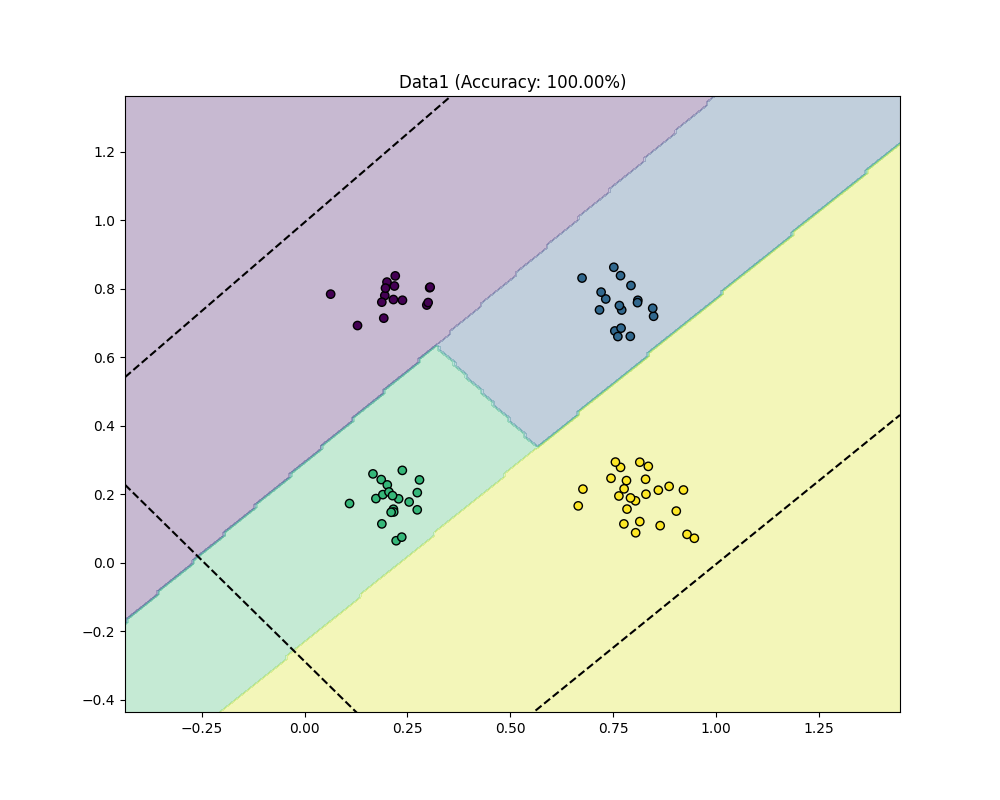

Depth 0: Splitting 304 points into 80/224 (Gini: 0.491)
Depth 1: Splitting 224 points into 76/148 (Gini: 0.329)
Depth 1: Splitting 224 points into 78/146 (Gini: 0.325)
Depth 2: Splitting 146 points into 76/70 (Gini: 0.000)

Decision Tree Structure:
├── SVM: -0.83*x + 2.96*y + -2.49 >= 0
├── Left:
│   ├── SVM: 0.74*x + -3.15*y + -2.47 >= 0
│   ├── Left:
│   │   ├── SVM: 1.27*x + 0.49*y + -0.16 >= 0
│   │   ├── Left:
│   │   │   └── Class 3
│   │   └── Right:
│   │       └── Class 2
│   └── Right:
│       └── Class 4
└── Right:
    └── Class 1


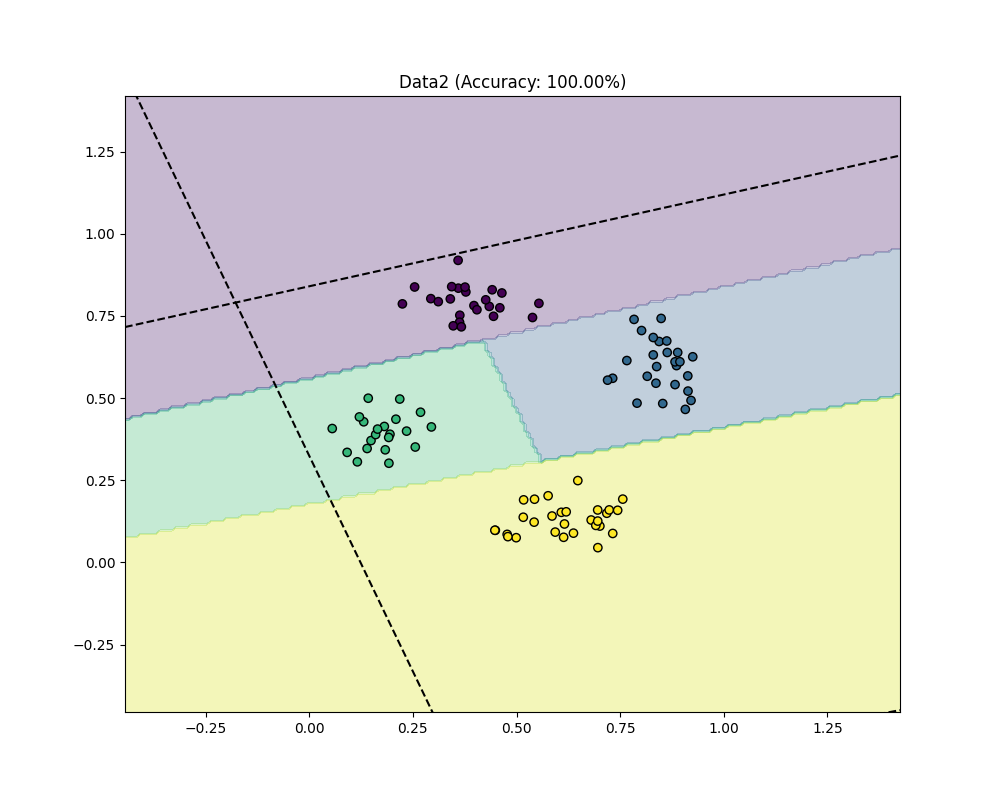

Depth 0: Splitting 300 points into 97/203 (Gini: 0.480)
Depth 1: Splitting 203 points into 0/203 (Gini: 0.577)
Depth 1: Splitting 203 points into 102/101 (Gini: 0.292)
Depth 1: Splitting 203 points into 88/115 (Gini: 0.194)
Depth 2: Splitting 115 points into 15/100 (Gini: 0.067)
Depth 2: Splitting 88 points into 0/88 (Gini: 0.087)
Depth 1: Splitting 97 points into 88/9 (Gini: 0.133)
Depth 2: Splitting 88 points into 88/0 (Gini: 0.146)

Decision Tree Structure:
├── SVM: -0.12*x + -2.49*y + -0.96 >= 0
├── Left:
│   ├── SVM: -3.79*x + -0.50*y + -0.90 >= 0
│   ├── Left:
│   │   ├── SVM: -1.38*x + -3.37*y + 0.90 >= 0
│   │   ├── Left:
│   │   │   └── Class 2
│   │   └── Right:
│   │       └── Class 1
│   └── Right:
│       ├── SVM: 0.11*x + 0.02*y + -0.96 >= 0
│       ├── Left:
│       │   └── Class 3
│       └── Right:
│           └── Class -1
└── Right:
    ├── SVM: 1.95*x + -2.71*y + -0.78 >= 0
    ├── Left:
    │   └── Class 3
    └── Right:
        ├── SVM: 0.18*x + -0.25*y + 0.86 >= 0

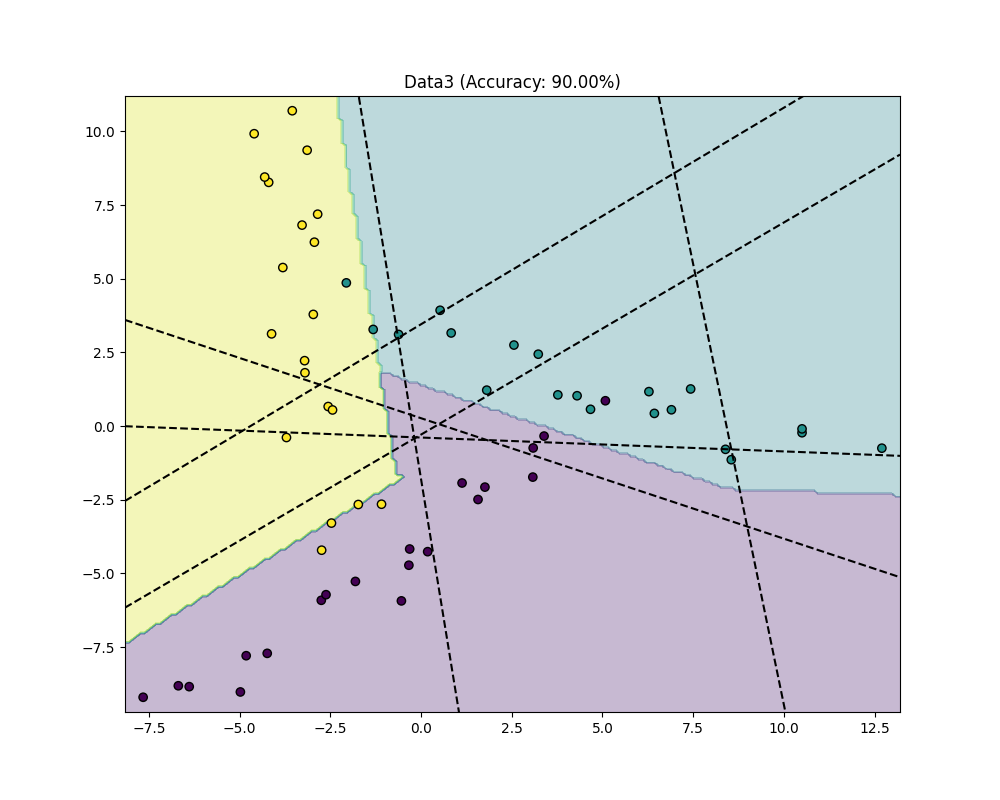

Depth 0: Splitting 432 points into 66/366 (Gini: 0.577)
Depth 0: Splitting 432 points into 135/297 (Gini: 0.545)
Depth 0: Splitting 432 points into 107/325 (Gini: 0.501)
Depth 0: Splitting 432 points into 106/326 (Gini: 0.493)
Depth 0: Splitting 432 points into 222/210 (Gini: 0.490)
Depth 1: Splitting 210 points into 0/210 (Gini: 0.536)
Depth 1: Splitting 210 points into 105/105 (Gini: 0.073)
Depth 2: Splitting 105 points into 0/105 (Gini: 0.056)
Depth 2: Splitting 105 points into 0/105 (Gini: 0.091)
Depth 1: Splitting 222 points into 65/157 (Gini: 0.120)
Depth 2: Splitting 157 points into 0/157 (Gini: 0.110)
Depth 2: Splitting 65 points into 65/0 (Gini: 0.142)

Decision Tree Structure:
├── Left:
│   ├── Left:
│   │   ├── Left:
│   │   │   └── Class 4
│   │   └── Right:
│   │       └── Class -1
│   └── Right:
│       ├── Left:
│       │   └── Class 3
│       └── Right:
│           └── Class -1
└── Right:
    ├── Left:
    │   ├── Left:
    │   │   └── Class 2
    │   └── Right:
    │  

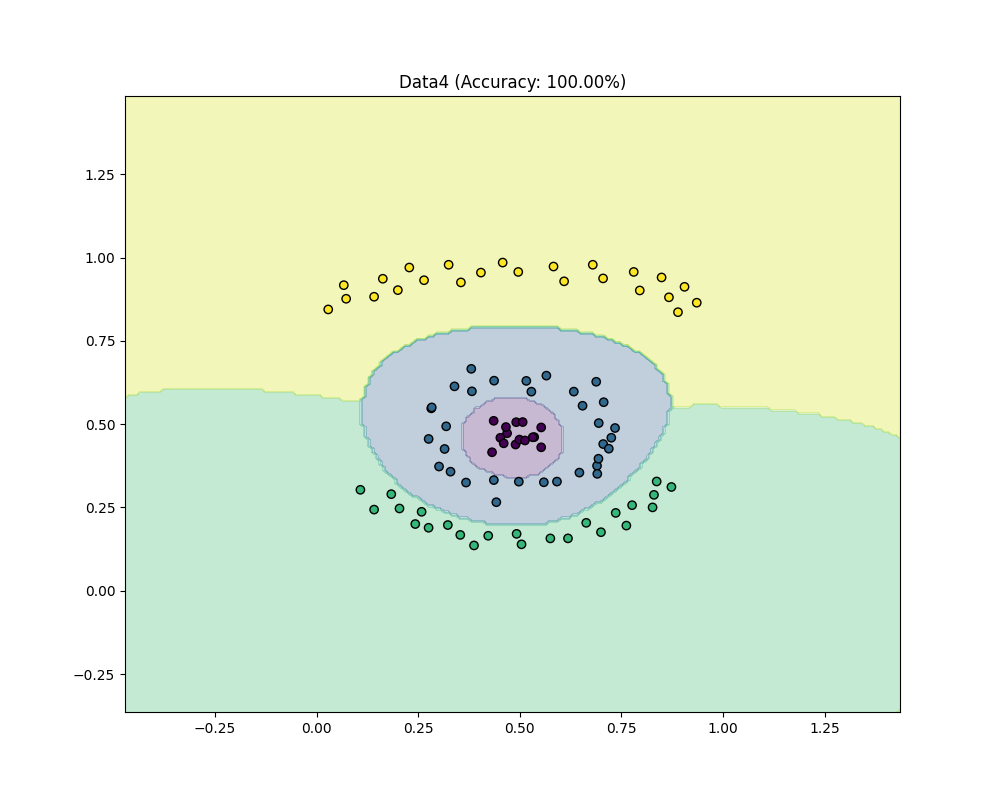


Results:
Data1: Accuracy = 100.00%
Data2: Accuracy = 100.00%
Data3: Accuracy = 90.00%
Data4: Accuracy = 100.00%

Data4 - Train vs. Test overlap:
Unique train points: 432
Unique test points: 96


In [84]:
# Main Execution
def main():
    plt.close('all')
    datasets = ['Data1', 'Data2', 'Data3', 'Data4']
    results = []
    
    for ds in datasets:
        X_train, y_train = load_data(f"{ds}Train.csv", data_dir="data")
        X_test, y_test = load_data(f"{ds}Test.csv", data_dir="data")
        
        # scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        kernel = 'rbf' if ds.lower() == 'data4' else 'linear'
        num_classes = len(np.unique(y_train))
        max_depth = int(np.ceil(np.log2(num_classes)) + 1)
        
        tree = build_tree(X_train_scaled, y_train, max_depth=max_depth, kernel=kernel)
        print("\nDecision Tree Structure:")
        print_tree(tree)
        y_pred = [predict(tree, x) for x in X_test_scaled]
        acc = accuracy_score(y_test, y_pred)
        results.append((ds, acc))

        # uncomment to visualize train points
        # visualize_tree(tree, X_train, y_train, scaler, title=f"{ds} (Accuracy: {acc:.2%})")
        visualize_tree(tree, X_test, y_test, scaler, title=f"{ds} (Accuracy: {acc:.2%})")
    
    print("\nResults:")
    for ds, acc in results:
        print(f"{ds}: Accuracy = {acc:.2%}")

    print(f"\n{ds} - Train vs. Test overlap:")
    print("Unique train points:", len(np.unique(X_train, axis=0)))
    print("Unique test points:", len(np.unique(X_test, axis=0)))

if __name__ == "__main__":
    main()